In [1]:
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.metrics import f1_score
from matplotlib.pyplot import figure
from sklearn import metrics

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape((60000, 28, 28))
x_train = x_train.astype('float32') / 255
x_test = x_test.reshape((10000, 28, 28))
x_test = x_test.astype('float32') / 255

y_train_non_cat = y_train
y_test_non_cat = y_test
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [3]:
x_train[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

In [4]:
y_train[6]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
def convolution(image, filt, s=1):
   
    (f, _) = filt.shape # filter dimensions
    in_dim, _ = image.shape # image dimensions
    
    out_dim = int((in_dim - f)/s)+1 # calculate output dimensions
  
    out = np.zeros((out_dim,out_dim))
    
    # convolve the filter over the image
    
    curr_y = out_y = 0
    while curr_y + f <= in_dim:
        curr_x = out_x = 0
        while curr_x + f <= in_dim:
            out[ out_y, out_x] = np.sum(filt * image[curr_y:curr_y+f, curr_x:curr_x+f])
            curr_x += s
            out_x += 1
        curr_y += s
        out_y += 1
        
    return out

def convolutionBackward(dconv_prev, conv_in, filt, s=1):
    '''
    Backpropagation through a convolutional layer. 
    '''
    (f, _) = filt.shape
    (orig_dim, _) = conv_in.shape
    dout = np.zeros(conv_in.shape) 
    dfilt = np.zeros(filt.shape)
    
    curr_y = out_y = 0
    while curr_y + f <= orig_dim:
        curr_x = out_x = 0
        while curr_x + f <= orig_dim:
            # loss gradient of filter (used to update the filter)
            dfilt += dconv_prev[out_y, out_x] * conv_in[curr_y:curr_y+f, curr_x:curr_x+f]
            # loss gradient of the input to the convolution operation (conv1 in the case of this network)
            dout[curr_y:curr_y+f, curr_x:curr_x+f] += dconv_prev[out_y, out_x] * filt
            curr_x += s
            out_x += 1
        curr_y += s
        out_y += 1
    
    return dout, dfilt


def maxpool(image, f=2, s=2):
    '''
    Downsample `image` using kernel size `f` and stride `s`
    '''
    h_prev, w_prev = image.shape
    
    h = int((h_prev - f)/s)+1
    w = int((w_prev - f)/s)+1
    
    downsampled = np.zeros((h, w))
    
    curr_y = out_y = 0
    while curr_y + f <= h_prev:
        curr_x = out_x = 0
        while curr_x + f <= w_prev:
            downsampled[out_y, out_x] = np.max(image[curr_y:curr_y+f, curr_x:curr_x+f])
            curr_x += s
            out_x += 1
        curr_y += s
        out_y += 1
    return downsampled

def maxpoolBackward(dpool, orig, f=2, s=2):
    (orig_dim, _) = orig.shape
    
    dout = np.zeros(orig.shape)
    
    curr_y = out_y = 0
    while curr_y + f <= orig_dim:
        curr_x = out_x = 0
        while curr_x + f <= orig_dim:
            # obtain index of largest value in input for current window
            (a, b) = nanargmax(orig[ curr_y:curr_y+f, curr_x:curr_x+f])
            dout[curr_y+a, curr_x+b] = dpool[ out_y, out_x]

            curr_x += s
            out_x += 1
        curr_y += s
        out_y += 1

    return dout

def nanargmax(arr):
    idx = np.nanargmax(arr)
    idxs = np.unravel_index(idx, arr.shape)
    return idxs  

def softmax(X):
    out = np.exp(X)
    return out/np.sum(out)

def categoricalCrossEntropy(probs, label):
    return -np.sum(label * np.log(probs))

def init_params():
    K1 = np.random.rand(32,3,3)
    K2 = np.random.rand(64,32,3,3)
    W1 = np.random.rand(128, 1600)/2000
    W2 = np.random.rand(10, 128)/40
    return K1,K2,W1,W2


def forward_prop(K1,K2,W1, W2, X):
#     A1 = np.zeros((K1.shape[0],(X.shape[1]-K1.shape[1]+1),(X.shape[1]-K1.shape[1]+1)))
#     A2 = np.zeros((K1.shape[0],(int((A1.shape[1] - 2)/2)+1),(int((A1.shape[1] - 2)/2)+1)))
#     A3 = np.zeros((K2.shape[0],(A2.shape[1]-K2.shape[2]+1),(A2.shape[1]-K2.shape[2]+1)))
#     A4 = np.zeros((K2.shape[0],(int((A3.shape[1] - 2)/2)+1),(int((A3.shape[1] - 2)/2)+1)))
#     print(A1.shape,A2.shape,A3.shape,A4.shape)
    
    A1 = np.zeros((32,26,26))
    A2 = np.zeros((32,13,13))
    A3 = np.zeros((64,11,11))
    A4 = np.zeros((64,5,5))
    
    for i in range(K1.shape[0]):
        A1[i] = convolution(X, K1[i])
    for i in range(K1.shape[0]):
        A2[i] = maxpool(A1[i])
        
    A3_i_sum = np.zeros((11,11)) 
    for i in range(K2.shape[0]):
        for j in range(K2.shape[1]):
            A3_i_sum = A3_i_sum + convolution(A2[j], K2[i][j])
        A3[i] = A3_i_sum
        A3_i_sum = np.zeros((11,11))
    
    for i in range(K2.shape[0]):
        A4[i] = maxpool(A3[i])
    
    A5 = A4.flatten()  
    A6 = (W1).dot(A5)
    A7 = W2.dot(A6)
    A8 = softmax(A7)
    return A8,A7,A6,A5,A4,A3,A2,A1


    
    
def backward_prop(A8,A7,A6,A5,A4,A3,A2,A1,X,y,K1,K2,W1,W2):
    dA7 = (A8 - y).reshape(10,1)
    dW2 =  (dA7).dot(A6.reshape(128,1).T)
    dA6 = (((W2.T).dot(dA7)))
    dW1 = (dA6).dot(A5.reshape(1600,1).T)
    dA5 = ((W1.T).dot(dA6)).reshape(64,5,5)
    
    dA4 = np.zeros((64,11,11))
    for i in range(K2.shape[0]):
        dA4[i] = maxpoolBackward(dA5[i],A3[i])
    
    dK2 = np.zeros((64,32,3,3))
    dA3 = np.zeros((32,13,13))
    for i in range(dK2.shape[0]):
        for j in range(dK2.shape[1]):
            dA3[j], dK2[i][j] = convolutionBackward(dA4[i],A2[j],K2[i][j])
            
    dA2 = np.zeros((32,26,26))        
    for i in range(K1.shape[0]):
        dA2[i] = maxpoolBackward(dA3[i],A1[i])
        
    dK1 = np.zeros((32,3,3))  
    for i in range(K1.shape[0]):
        _, dK1[i] = convolutionBackward(dA2[i],X,K1[i])
        
    return dW2,dW1,dK2,dK1
    

In [7]:
def update_params(W1, W2, dW1, dW2, alpha,K1,K2,dK1,dK2):
    W1 = W1 - alpha * dW1   
    W2 = W2 - alpha * dW2    
    K1 = K1 - alpha * dK1   
    K2 = K2 - alpha * dK2    
    return W1, W2, K1, K2

In [8]:
def get_predictions(y_proba):
    return np.argmax(y_proba)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

In [9]:
def gradient_descent(X, Y, Y_non_cat, alpha, iterations):
    K1,K2,W1,W2 = init_params()
    for i in range(iterations):
        loss = 0
        pred = np.zeros((len(Y),1)).astype(int)
        for j in range(len(Y)):
            A8,A7,A6,A5,A4,A3,A2,A1 = forward_prop(K1,K2,W1, W2, X[j])         
            dW2,dW1,dK2,dK1 = backward_prop(A8,A7,A6,A5,A4,A3,A2,A1,X[j],Y[j],K1,K2,W1,W2)
#             print(dW2,dW1,dK2,dK1)
            W1, W2, K1, K2 =  update_params(W1, W2, dW1, dW2, alpha,K1,K2,dK1,dK2) 
            loss = loss + categoricalCrossEntropy(A8,Y[j])   
            pred[j]=get_predictions(A8)
        pred = pred.flatten()
#         print('pred:',pred)
#         print('real:',Y_non_cat)
        if i % 1 == 0:
            print(f"epoch: [{i+1}/{iterations}], train_loss={np.round(loss,8)}, \
            train_acc={np.round(get_accuracy(pred,Y_non_cat),8)}")

    return K1,K2,W1,W2

In [10]:
num = 100

In [16]:
%%time 
K1,K2,W1,W2 = gradient_descent(x_train[:num],y_train[:num],y_train_non_cat[:num],0.000001,20)

epoch: [1/20], train_loss=446.30733941,             train_acc=0.11
epoch: [2/20], train_loss=237.28247112,             train_acc=0.19
epoch: [3/20], train_loss=197.05136971,             train_acc=0.35
epoch: [4/20], train_loss=171.955847,             train_acc=0.42
epoch: [5/20], train_loss=154.1671247,             train_acc=0.48
epoch: [6/20], train_loss=140.44953586,             train_acc=0.48
epoch: [7/20], train_loss=129.2979869,             train_acc=0.54
epoch: [8/20], train_loss=119.94795327,             train_acc=0.58
epoch: [9/20], train_loss=111.94181645,             train_acc=0.62
epoch: [10/20], train_loss=104.97382572,             train_acc=0.63
epoch: [11/20], train_loss=98.84667671,             train_acc=0.64
epoch: [12/20], train_loss=93.45361516,             train_acc=0.64
epoch: [13/20], train_loss=88.7263944,             train_acc=0.71
epoch: [14/20], train_loss=84.58035323,             train_acc=0.71
epoch: [15/20], train_loss=80.91256982,             train_acc=0.73

In [17]:
num = 1000

In [13]:
def test_acc(K1,K2,W1, W2, X, Y):
    pred = np.zeros((len(Y),1)).astype(int)
    pred_proba = []
    for j in range(len(Y)):
                A8,_,_,_,_,_,_,_ = forward_prop(K1,K2,W1, W2, X[j])
                pred_proba.append(A8)
                pred[j] = get_predictions(A8)
    pred = pred.flatten()
#     print(pred)
#     print(Y)
    
    print('f1 scores for every class:', np.round(f1_score(Y, pred, average=None),3))
    
    return get_accuracy(pred, Y[:len(Y)]),pred, pred_proba

In [19]:
test_acc(K1,K2,W1, W2, x_test[:num], y_test_non_cat[:num])

0.592

In [12]:
def gradient_descent_tune(X, Y, Y_non_cat, alpha, iterations,K1,K2,W1,W2):
#     K1,K2,W1,W2 = init_params()
    for i in range(iterations):
        loss = 0
        pred = np.zeros((len(Y),1)).astype(int)
        for j in range(len(Y)):
            A8,A7,A6,A5,A4,A3,A2,A1 = forward_prop(K1,K2,W1, W2, X[j])         
            dW2,dW1,dK2,dK1 = backward_prop(A8,A7,A6,A5,A4,A3,A2,A1,X[j],Y[j],K1,K2,W1,W2)
#             print(dW2,dW1,dK2,dK1)
            W1, W2, K1, K2 =  update_params(W1, W2, dW1, dW2, alpha,K1,K2,dK1,dK2) 
            loss = loss + categoricalCrossEntropy(A8,Y[j])   
            pred[j]=get_predictions(A8)
        pred = pred.flatten()
#         print('pred:',pred)
#         print('real:',Y_non_cat)
        if j % 1 == 0:
            print(f"epoch: [{i+1}/{iterations}], train_loss={np.round(loss,8)}, \
            train_acc={np.round(get_accuracy(pred,Y_non_cat),8)}")

    return K1,K2,W1,W2

In [23]:
%%time 
K1,K2,W1,W2 = gradient_descent_tune(x_train[:num],y_train[:num],y_train_non_cat[:num],0.000001,20,K1,K2,W1,W2)

epoch: [1/20], train_loss=64.90612672,             train_acc=0.79
epoch: [2/20], train_loss=62.87336969,             train_acc=0.79
epoch: [3/20], train_loss=60.96643668,             train_acc=0.8
epoch: [4/20], train_loss=59.17302501,             train_acc=0.8
epoch: [5/20], train_loss=57.48259565,             train_acc=0.8
epoch: [6/20], train_loss=55.88595267,             train_acc=0.82
epoch: [7/20], train_loss=54.37496488,             train_acc=0.82
epoch: [8/20], train_loss=52.94237784,             train_acc=0.83
epoch: [9/20], train_loss=51.58168232,             train_acc=0.83
epoch: [10/20], train_loss=50.28701797,             train_acc=0.83
epoch: [11/20], train_loss=49.0530987,             train_acc=0.83
epoch: [12/20], train_loss=47.87515199,             train_acc=0.83
epoch: [13/20], train_loss=46.74886707,             train_acc=0.84
epoch: [14/20], train_loss=45.67034964,             train_acc=0.84
epoch: [15/20], train_loss=44.63608122,             train_acc=0.85
epoch: [

In [24]:
num = 1000

In [25]:
test_acc(K1,K2,W1, W2, x_test[:num], y_test_non_cat[:num])

0.625

In [14]:
num = 400

In [32]:
%%time 
K1,K2,W1,W2 = gradient_descent(x_train[:num],y_train[:num],y_train_non_cat[:num],0.000001,5)

epoch: [1/5], train_loss=1079.47450513,             train_acc=0.2
epoch: [2/5], train_loss=575.92027015,             train_acc=0.53
epoch: [3/5], train_loss=451.86789367,             train_acc=0.6425
epoch: [4/5], train_loss=389.73945006,             train_acc=0.69
epoch: [5/5], train_loss=351.23404867,             train_acc=0.715
CPU times: total: 1h 35min 27s
Wall time: 1h 35min 29s


In [35]:
test_acc(K1,K2,W1, W2, x_test[:num], y_test_non_cat[:num])

0.6675

In [38]:
%%time 
K1,K2,W1,W2 = gradient_descent_tune(x_train[:num],y_train[:num],y_train_non_cat[:num],0.000001,2,K1,K2,W1,W2)

epoch: [1/2], train_loss=323.99645828,             train_acc=0.7325
epoch: [2/2], train_loss=303.15873879,             train_acc=0.74
CPU times: total: 38min 13s
Wall time: 38min 13s


In [39]:
test_acc(K1,K2,W1, W2, x_test[:num], y_test_non_cat[:num])

0.69

In [41]:
with open('w.npy', 'wb') as f:
    np.save(f, K1)
    np.save(f, K2)
    np.save(f, W1)
    np.save(f, W2)

In [10]:
with open('w.npy', 'rb') as f:
    K1 = np.load(f)
    K2 = np.load(f)
    W1 = np.load(f)
    W2 = np.load(f)

In [15]:
%%time 
K1,K2,W1,W2 = gradient_descent_tune(x_train[:num],y_train[:num],y_train_non_cat[:num],0.000001,3,K1,K2,W1,W2)

epoch: [1/3], train_loss=286.39913923,             train_acc=0.76
epoch: [2/3], train_loss=272.45398944,             train_acc=0.76
epoch: [3/3], train_loss=260.57390875,             train_acc=0.7725
CPU times: total: 57min 38s
Wall time: 57min 39s


In [16]:
test_acc(K1,K2,W1, W2, x_test[:num], y_test_non_cat[:num])

0.7375

In [17]:
%%time 
K1,K2,W1,W2 = gradient_descent_tune(x_train[:num],y_train[:num],y_train_non_cat[:num],0.000001,2,K1,K2,W1,W2)

epoch: [1/2], train_loss=250.28296988,             train_acc=0.7825
epoch: [2/2], train_loss=241.25914835,             train_acc=0.795
CPU times: total: 37min 46s
Wall time: 37min 47s


In [18]:
test_acc(K1,K2,W1, W2, x_test[:num], y_test_non_cat[:num])

0.76

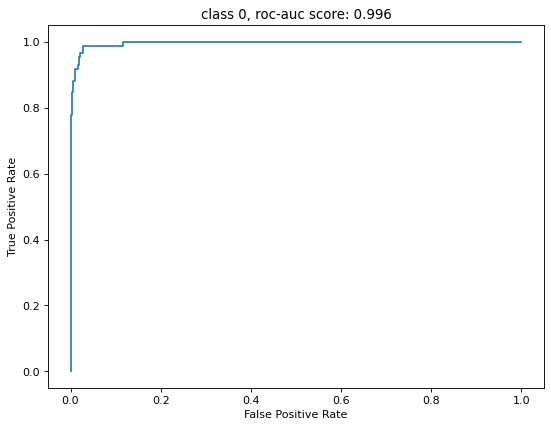

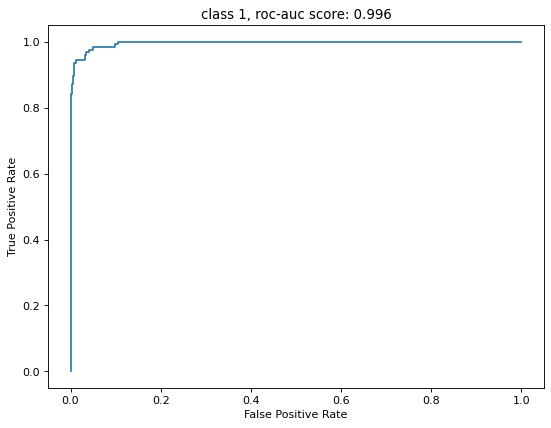

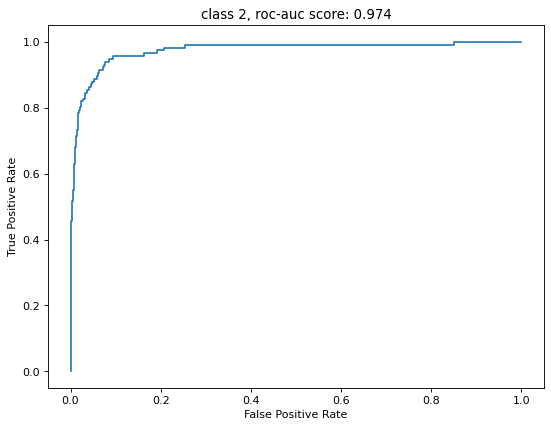

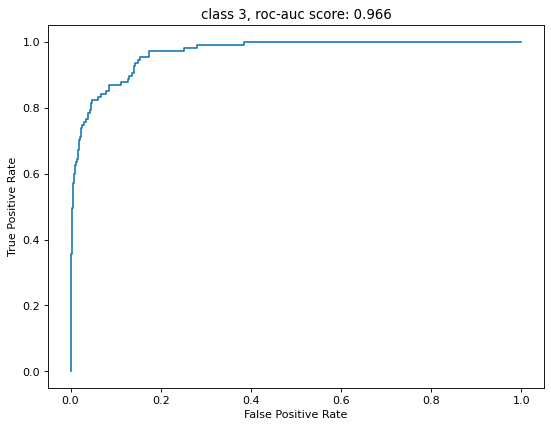

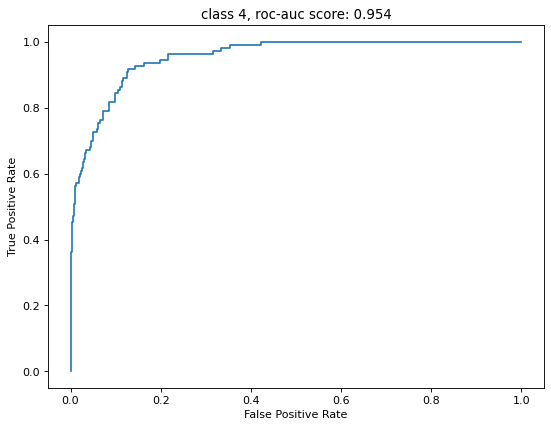

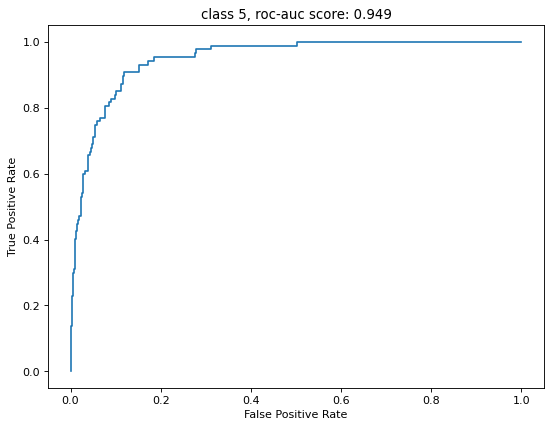

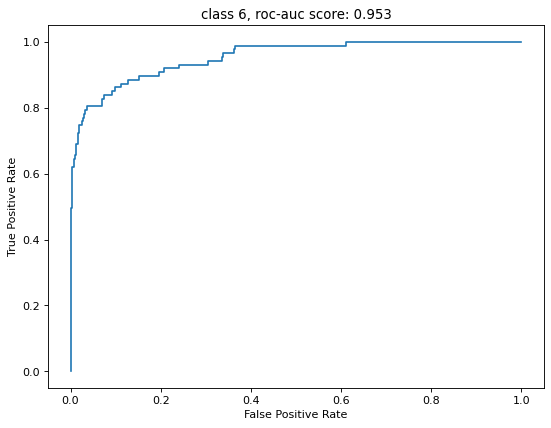

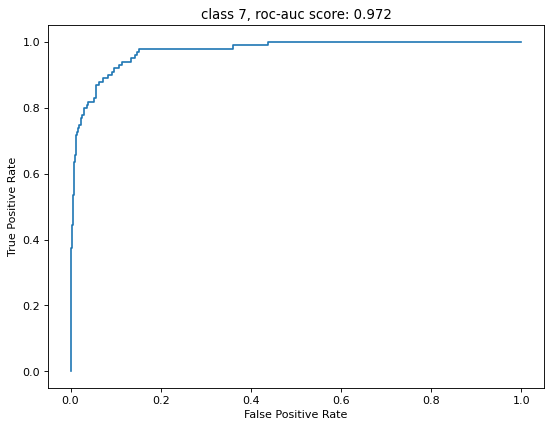

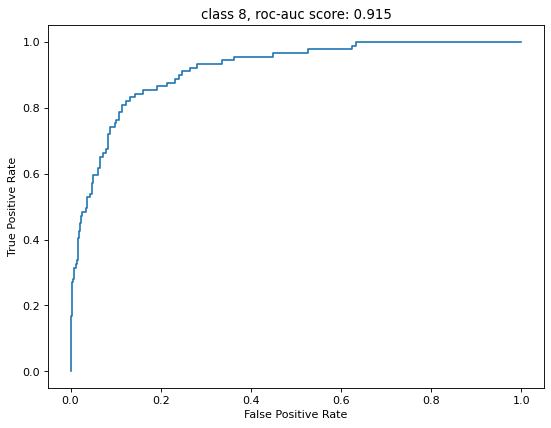

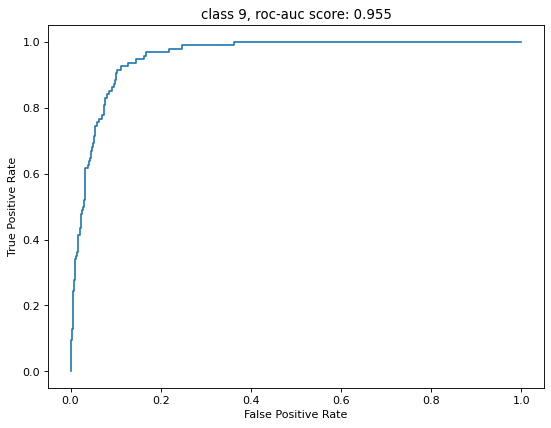

In [59]:
for i in range(10):
    cl_proba = np.zeros((num,1))
    y_real_cl = np.zeros((num,1))
    for j in range(num):
        cl_proba[j] = pred_proba[j][i]
        if y_test_non_cat[j]==i: 
            y_real_cl[j]=1
        else: 
            y_real_cl[j]=0
        
    fpr, tpr, _ = metrics.roc_curve(y_real_cl, cl_proba)

    figure(figsize=(8, 6), dpi=80)
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(f'class {i}, roc-auc score: {np.round(metrics.roc_auc_score(y_real_cl, cl_proba),3)}')
    plt.show()

In [14]:
num = 10000

In [15]:
%%time
acc, pred, pred_proba = test_acc(K1,K2,W1, W2, x_test[:num], y_test_non_cat[:num])

f1 scores for every class: [0.872 0.896 0.798 0.809 0.691 0.648 0.777 0.83  0.59  0.639]
CPU times: total: 3h 12min 15s
Wall time: 3h 12min 21s


In [57]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test_non_cat[:num], pred)

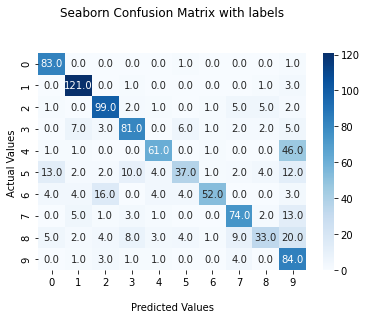

In [58]:
ax = sns.heatmap(num*cf_matrix/np.sum(cf_matrix), annot=True,
fmt='2', cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()